# EDA

**In this notebook, we will explore the data by creating different sorts of visualizations of the play by play data. The goal is to find variables which would be interesting for our win probability model.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
import seaborn.apionly as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib  import cm
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

In [3]:
# import scraped data
pbp = pd.read_csv("pbp.csv")
pbp = pbp.iloc[:,1:]

In [8]:
pbp.describe()

,isawayevent,awayscore,homescore,quarter,gameID,isAssist,isOffRebound,isDefRebound,is3ptShot,is2ptShot,isFT,isMade,isMissed,isTurnover,shotDistance,awayRun,awayLead,minutesRemaining,points_on_play,AWAY_WIN
count,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000
mean,0.508297,53.179869,54.482695,2.521930,142.814555,0.097695,0.068118,0.157666,0.126185,0.246921,0.096599,0.243890,0.225814,0.003212,4.945175,-0.112454,-1.302826,23.349436,0.459284,0.424998
std,0.499933,31.388282,32.029916,1.118093,83.357931,0.296903,0.251949,0.364429,0.332058,0.431222,0.295413,0.429429,0.418119,0.056581,9.027741,3.971640,11.214979,13.877395,0.877616,0.494345
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,-49.000000,0.000000,0.000000,0.000000
25%,0.000000,26.000000,27.000000,2.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,-8.000000,11.433333,0.000000,0.000000
50%,1.000000,52.000000,54.000000,3.000000,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,23.733333,0.000000,0.000000
75%,1.000000,79.000000,81.000000,4.000000,215.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,5.000000,35.466667,0.000000,1.000000
max,1.000000,142.000000,146.000000,4.000000,288.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,86.000000,19.000000,58.000000,48.000000,3.000000,1.000000


## EDA Findings
- The mean value for Offensive Rebounds compared to Defensive Rebounds is 0.0681 and 0.1576 respectively. This tells us that Offensive Rebounds are much less common than Defensive Rebounds. Perhaps this will be an important factor in the model given that offensive rebounds lead to more scoring opportunities.
- We can see that the mean value for 3pt and 2pt shots respectively are 0.1262 and 0.2469 showing that 3pt attempts are half as likely as 2pt shots, i.e. one third of shot attempts are 3pt shots.
- Another interesting find is that the average shot distance is 14.5 ft with a standard deviation of 10 ft. 
- Additionally, we can see that 40% of shots made were assisted. When looking at made shots exclusively, we see that 51% are 2pt shots, 18.6% are 3pt shots, and 30.4% are free throws. On the other hand, looking at misses exclusively, we see that 54.3% of missed shots are 2pt, 35.7% are 3pt, and 10% are free throws
- We also noted that the average away lead is -1.3 suggesting that the home team leads on average during the play by play calls. This works with away win percentage, 42.76%, suggesting that the away not only trails the home team on average but they also win less than 50% of the team.
- On average, the points per shot is 1 as expected. This suggests that teams are hitting 2pt shots with 50% accuracy typically and 3pt shots with 33% accuracy. See below for a comparison per team.


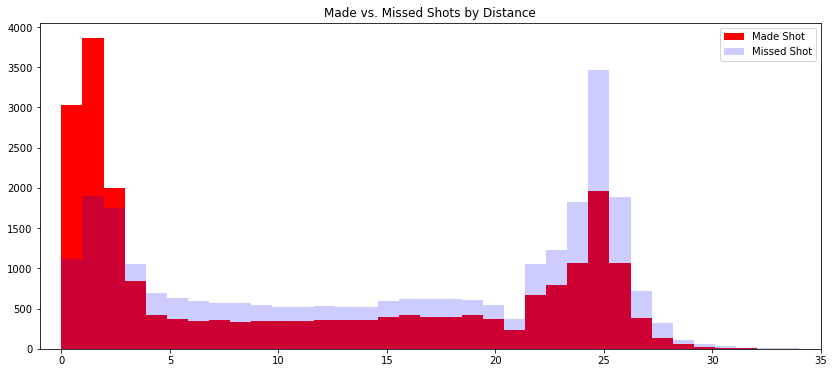

In [4]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
made = pbp[(pbp['isMade'] == 1) & (pbp['isFT'] == 0) & (pbp['shotDistance'] < 35)]
missed = pbp[(pbp['isMissed'] == 1) & (pbp['isFT'] == 0) & (pbp['shotDistance'] < 35)]
made['shotDistance'].hist(bins=35, figsize=[14,6], color='red', label='Made Shot')
missed['shotDistance'].hist(bins=35, figsize=[14,6], alpha=0.2, color='blue', label="Missed Shot")
ax.legend(loc='best')
ax.grid(False)
ax.set_xlim(-1,35)
plt.title("Made vs. Missed Shots by Distance")

**This plot shows us that shots around the rim are higher in conversion rate than distant shots, however they are attempted with similar rates. **

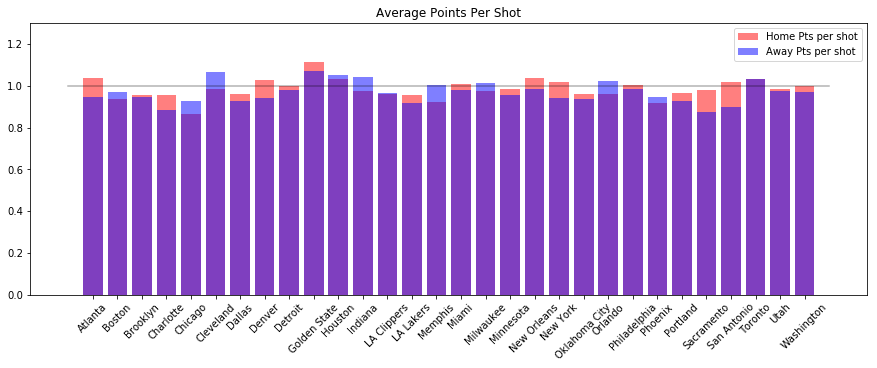

In [6]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
teams = pbp.awayteam.unique()
teams.sort()
y_pos = np.arange(len(teams))
avg_home = pbp[(pbp.isawayevent == 0) & ((pbp.isMade == 1) | (pbp.isMissed == 1))].groupby(['hometeam'])['points_on_play'].mean()
avg_away = pbp[(pbp.isawayevent == 1) & ((pbp.isMade == 1) | (pbp.isMissed == 1))].groupby(['awayteam'])['points_on_play'].mean()

plt.bar(y_pos, avg_home, align='center', alpha=0.5, color='red', label='Home Pts per shot')
plt.bar(y_pos, avg_away, align='center', alpha=0.5, color='blue', label='Away Pts per shot')
plt.xticks(y_pos, teams)
plt.plot((-1, 30), (1, 1), 'black', alpha=0.3)
ax.legend(loc='best')
ax.set_ylim(0,1.3)
plt.title('Average Points Per Shot')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

**This plot shows which teams out perform the 1pt per shot expected average and shows which teams shoot better home vs away**

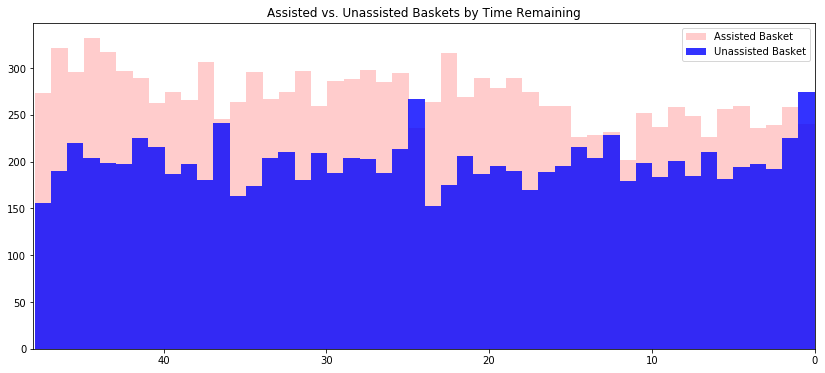

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
assisted = pbp[(pbp['isMade'] == 1) & (pbp['isAssist'] == 1) & (pbp['isFT'] == 0)]
unassisted = pbp[(pbp['isMade'] == 1) & (pbp['isAssist'] == 0) & (pbp['isFT'] == 0)]
assisted['minutesRemaining'].hist(bins=48, figsize=[14,6], alpha=0.2, color='red', label='Assisted Basket')
unassisted['minutesRemaining'].hist(bins=48, figsize=[14,6], alpha=0.8, color='blue', label="Unassisted Basket")
ax.legend(loc='best')
ax.grid(False)
ax.set_xlim(48,0)
plt.title("Assisted vs. Unassisted Baskets by Time Remaining")

**This plot gives us a sense of how teams are passing the ball depending on the amount of time left. It appears that players get slightly more selfish near the end of quarters.**